In [2]:
import os
import math
import skimage
import scipy as sp
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import SimpleITK as sitk
from nibabel import processing

C:\Users\e.lavrova\AppData\Local\Continuum\anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
import pydicom

In [4]:
from PIL import Image, ImageDraw

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [6]:
import nrrd

In [545]:
folder = "Z:/Lisa/PLAQUE/Plaque_imaging_data/"

In [547]:
for item in os.listdir(folder):
    subfolder = os.path.join(folder, item)
    if os.path.isdir(subfolder):
        
        dicom_files_df = []

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)
            if os.path.isfile(subpath)&('.dcm' in subpath):
                d = {'filename': subpath}
                ds = pydicom.dcmread(subpath, force = True)
                dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                d['dim_0'] = dcm.pixel_array.shape[0]
                d['dim_1'] = dcm.pixel_array.shape[1]
                d['pixel_spacing_0'] = float(ds.PixelSpacing[0])
                d['pixel_spacing_1'] = float(ds.PixelSpacing[0])
                d['SOPInstanceUID'] = ds.SOPInstanceUID
                d['SeriesInstanceUID'] = ds.SeriesInstanceUID
                d['image_position_0'] = ds.ImagePositionPatient[0]
                d['image_position_1'] = ds.ImagePositionPatient[1]
                d['image_position_2'] = ds.ImagePositionPatient[2]
                d['StudyInstanceUID'] = ds.StudyInstanceUID
                d['SeriesDescription'] = ds.SeriesDescription.rstrip('\x00')
                dicom_files_df.append(d)

        dicom_files_df = pd.DataFrame(dicom_files_df)

        dicom_files_df.sort_values(by = ['SeriesInstanceUID', 'image_position_2'], inplace = True)

        series = dicom_files_df['SeriesInstanceUID'].unique()

        dicom_series_df = []

        for ser in series:

            d = {'SeriesInstanceUID': ser}

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_0'].unique()):
                d['dim_0'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_0'].unique()[0]
            else:
                print ('Dims not equal between slices')
                d['dim_0'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_1'].unique()):
                d['dim_1'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_1'].unique()[0]
            else:
                print ('Dims not equal between slices')
                d['dim_1'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].unique()):
                d['pixel_spacing_0'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].unique()[0]
            else:
                print ('Pix spacings not equal between slices')
                d['pixel_spacing_0'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].unique()):
                d['pixel_spacing_1'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].unique()[0]
            else:
                print ('Pix spacings not equal between slices')
                d['pixel_spacing_1'] = None

            d['number_of_slices'] = len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser])

            zs = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['image_position_2'].values
            d['between_slices'] = np.mean(np.diff(zs))

            dicom_series_df.append(d)

        dicom_series_df = pd.DataFrame(dicom_series_df)

        for ser in series:

            img = np.zeros((dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_0'].values[0], 
                            dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_1'].values[0], 
                            dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['number_of_slices'].values[0]))

            for i_slice in range (0, dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['number_of_slices'].values[0]):

                ds = pydicom.dcmread(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['filename'].values[i_slice], 
                                     force = True)
                ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                img[..., i_slice] = ds.pixel_array

            header = {
                      'spacings': [dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].values[0], 
                                   dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].values[0], 
                                   dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['between_slices'].values[0]], 
                      'sizes': [dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_0'].values[0], 
                                dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_1'].values[0], 
                                dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['number_of_slices'].values[0]]}    

            nrrd.write(subfolder + '/' + dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['SeriesDescription'].unique()[0] + '.nrrd', img, header)

In [686]:
#for item in os.listdir(folder):
for item in ['MUMC_011', 'MUMC-013']:
    subfolder = os.path.join(folder, item)
    if os.path.isdir(subfolder):
        
        dicom_files_df = []

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)
            if os.path.isfile(subpath)&('.dcm' in subpath):
                d = {'filename': subpath}
                ds = pydicom.dcmread(subpath, force = True)
                dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                d['dim_0'] = dcm.pixel_array.shape[0]
                d['dim_1'] = dcm.pixel_array.shape[1]
                d['pixel_spacing_0'] = float(ds.PixelSpacing[0])
                d['pixel_spacing_1'] = float(ds.PixelSpacing[0])
                d['SOPInstanceUID'] = ds.SOPInstanceUID
                d['SeriesInstanceUID'] = ds.SeriesInstanceUID
                d['image_position_0'] = ds.ImagePositionPatient[0]
                d['image_position_1'] = ds.ImagePositionPatient[1]
                d['image_position_2'] = ds.ImagePositionPatient[2]
                d['StudyInstanceUID'] = ds.StudyInstanceUID
                d['SeriesDescription'] = ds.SeriesDescription.rstrip('\x00')
                dicom_files_df.append(d)

        dicom_files_df = pd.DataFrame(dicom_files_df)

        dicom_files_df.sort_values(by = ['SeriesInstanceUID', 'image_position_2'], inplace = True)

        series = dicom_files_df['SeriesInstanceUID'].unique()

        dicom_series_df = []

        for ser in series:

            d = {'SeriesInstanceUID': ser, 
                 'description': dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['SeriesDescription'].unique()[0]}

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_0'].unique()):
                d['dim_0'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_0'].unique()[0]
            else:
                print ('Dims not equal between slices')
                d['dim_0'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_1'].unique()):
                d['dim_1'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_1'].unique()[0]
            else:
                print ('Dims not equal between slices')
                d['dim_1'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].unique()):
                d['pixel_spacing_0'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].unique()[0]
            else:
                print ('Pix spacings not equal between slices')
                d['pixel_spacing_0'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].unique()):
                d['pixel_spacing_1'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].unique()[0]
            else:
                print ('Pix spacings not equal between slices')
                d['pixel_spacing_1'] = None

            d['number_of_slices'] = len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser])

            zs = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['image_position_2'].values
            d['between_slices'] = np.mean(np.diff(zs))

            dicom_series_df.append(d)

        dicom_series_df = pd.DataFrame(dicom_series_df)

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)
            if os.path.isfile(subpath) & ('.BAK' in subpath) & (not '.nrrd' in subpath):

                with open(subpath) as f:
                    content = f.readlines()

                d = {'filename': subpath}
                for string in content:
                    if 'Study_UID' in string:
                        d['Study_UID'] = string[10:-1]
                    if 'Series_UID' in string:
                        d['Series_UID'] = string[11:-1]
                    if 'Series_description=' in string:
                        d['Series_description'] = string[19:-1]

                xycontour_firstline = []
                for i_string in range (0, len(content)):
                    if 'XYCONTOUR' in content[i_string]:
                        xycontour_firstline.append(i_string)

                contours = []

                for i_string in xycontour_firstline:
                    contour = {'slice_number': int(content[i_string+1].split(' ')[0])}
                    contour['ROI_number'] = int(content[i_string+1].split(' ')[2])
                    contour['scale'] = float(content[i_string+1].split(' ')[4][:-1])
                    contour['length'] = int(content[i_string+2][:-1])
                    contour['coords'] = []
                    for coords in range (0, contour['length']):
                        contour['coords'].append(float(content[i_string+3+coords].split(' ')[0]))
                        contour['coords'].append(float(content[i_string+3+coords].split(' ')[1][:-1]))
                    contours.append(contour)

                contours = pd.DataFrame(contours)

                rois_unique = contours['ROI_number'].unique()

                masks = []

                for i_roi in range (0, len(rois_unique)):
                    mask = np.zeros((dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_0'].values[0],
                                     dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_1'].values[0],
                                     dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['number_of_slices'].values[0]))
                    masks.append(mask)

                for i_contour in range (0, len(contours)):
                    img = Image.new('1', (dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] 
                                                              == d['Series_UID']]['dim_0'].values[0], 
                                          dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] 
                                                              == d['Series_UID']]['dim_1'].values[0]))
                    ImageDraw.Draw(img).polygon(list(contours['coords'][i_contour]/contours['scale'][i_contour]), outline=1, fill=1)
                    i_roi, = np.where(rois_unique == contours['ROI_number'][i_contour])
                    masks[i_roi[0]][..., (contours['slice_number'][i_contour])] = ((np.array(img) + masks[i_roi[0]][..., contours['slice_number'][i_contour]]) > 0.9).astype(int)

                for i_mask in range (0, len(masks)):
                    
                    header = {
                      'spacings': [dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['pixel_spacing_0'].values[0], 
                                   dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['pixel_spacing_1'].values[0], 
                                   dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['between_slices'].values[0]], 
                      'sizes': [dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['dim_0'].values[0], 
                                dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['dim_1'].values[0], 
                                dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['number_of_slices'].values[0]]}    
                    
                    nrrd.write(d['filename'] + '_' + d['Series_description'] + '_' + str(rois_unique[i_mask]) + '.nrrd', masks[i_mask], header)

In [577]:
filename = "Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011/MUMC011_STD350928590_SER1001_ACQ10.con"

In [580]:
with open(filename) as f:
    content = f.readlines()

d = {'filename': subpath}
for string in content:
    if 'Study_UID' in string:
        d['Study_UID'] = string[10:-1]
    if 'Series_UID' in string:
        d['Series_UID'] = string[11:-1]
    if 'Series_description' in string:
        d['Series_description'] = string[19:-1]
    if 'Patient_ID' in string:
        d['Patient_ID'] = string[11:-1]

fcontour_firstline = []
for i_string in range (0, len(content)):
    if 'FCONTOUR' in content[i_string]:
        fcontour_firstline.append(i_string)
    
    contours = []

    for i_string in fcontour_firstline:
        
        contour = {'slice_number': int(content[i_string+1].split(' ')[0])}
        contour['ROI_number'] = int(content[i_string+1].split(' ')[2])
        contour['scale'] = float(content[i_string+1].split(' ')[4][:-1])
        contour['length'] = int(content[i_string+2][:-1])
        
        x = int(content[i_string+3].split(' ')[0])
        y = int(content[i_string+3].split(' ')[1][:-1])
        
        contour['coords'] = [x, y]
        contour['fcode'] = content[i_string+3][:-1]
                    
        for point in range (0, len(contour['fcode'])):
            
            if contour['fcode'] == 0:
                x += 1
            if contour['fcode'] == 1:
                x +=1
                y +=1
            if contour['fcode'] == 2:
                y += 1
            if contour['fcode'] == 3:
                x -= 1
                y += 1
            if contour['fcode'] == 4:
                x -= 1
            if contour['fcode'] == 5:
                x -= 1
                y -= 1
            if contour['fcode'] == 6:
                y -= 1
            if contour['fcode'] == 7:
                x += 1
                y -= 1
            
            contour['coords'].append(x)
            contour['coords'].append(y)
            contours.append(contour)

    contours = pd.DataFrame(contours)

In [581]:
contours

,ROI_number,coords,fcode,length,scale,slice_number
0,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
1,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
2,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
3,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
4,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
5,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
6,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
7,0,"[632, 1056, 632, 1056, 632, 1056, 632, 1056, 6...",632 1056,266,4.0,1
8,1,"[638, 1035, 638, 1035, 638, 1035, 638, 1035, 6...",638 1035,356,4.0,1
9,1,"[638, 1035, 638, 1035, 638, 1035, 638, 1035, 6...",638 1035,356,4.0,1


In [641]:
folder = "Z:/Lisa/PLAQUE/Plaque_imaging_data/"
dicom_files_df = []
con_files_df = []

for item in os.listdir(folder):
    subfolder = os.path.join(folder, item)
    if os.path.isdir(subfolder):

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)
            if os.path.isfile(subpath)&('.dcm' in subpath):
                d = {'filename': subpath, 'folder': item}
                ds = pydicom.dcmread(subpath, force = True)
                dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                d['dim_0'] = dcm.pixel_array.shape[0]
                d['dim_1'] = dcm.pixel_array.shape[1]
                d['pixel_spacing_0'] = float(ds.PixelSpacing[0])
                d['pixel_spacing_1'] = float(ds.PixelSpacing[0])
                d['SeriesInstanceUID'] = ds.SeriesInstanceUID
                d['StudyInstanceUID'] = ds.StudyInstanceUID
                d['PatientName'] = ds.PatientName
                d['PatientID'] = ds.PatientID.rstrip('\x00')
                dicom_files_df.append(d)
                
            if os.path.isfile(subpath)&('.con' in subpath) & (not '.nrrd' in subpath):
                with open(subpath) as f:
                    content = f.readlines()
                d = {'filename': subpath, 'folder': item}
                for string in content:
                    if 'Study_UID=' in string:
                        d['Study_UID'] = string[10:-1]
                    if 'Series_UID=' in string:
                        d['Series_UID'] = string[11:-1]
                    if 'Series_description=' in string:
                        d['Series_description'] = string[19:-1]
                    if 'Patient_id=' in string:
                        d['Patient_ID'] = string[11:-1]
                    if 'Patient_name=' in string:
                        d['Patient_name'] = string[13:-1]
                    if 'roi_00.roi_label=' in string:
                        d['roi_00_name'] = string[17:-1]
                    if 'roi_01.roi_label=' in string:
                        d['roi_01_name'] = string[17:-1]
                    if 'roi_02.roi_label=' in string:
                        d['roi_02_name'] = string[17:-1]
                    if 'roi_03.roi_label=' in string:
                        d['roi_03_name'] = string[17:-1]    
                    if 'roi_04.roi_label=' in string:
                        d['roi_04_name'] = string[17:-1]   
                    if 'roi_05.roi_label=' in string:
                        d['roi_05_name'] = string[17:-1]
                    if 'roi_06.roi_label=' in string:
                        d['roi_06_name'] = string[17:-1]
                    if 'roi_07.roi_label=' in string:
                        d['roi_07_name'] = string[17:-1]
                    if 'roi_08.roi_label=' in string:
                        d['roi_08_name'] = string[17:-1]
                    if 'roi_09.roi_label=' in string:
                        d['roi_09_name'] = string[17:-1]
                    if 'roi_10.roi_label=' in string:
                        d['roi_10_name'] = string[17:-1]

                con_files_df.append(d)

dicom_files_df = pd.DataFrame(dicom_files_df)
con_files_df = pd.DataFrame(con_files_df)

In [637]:
for item in dicom_files_df['folder'].unique():
    print (item) 
    print (dicom_files_df.loc[dicom_files_df['folder'] == item]['StudyInstanceUID'].unique())
    print (con_files_df.loc[con_files_df['folder'] == item]['Study_UID'].unique())

MUMC--027
['1.3.46.670589.11.38172.5.0.6532.2011051216393814344']
['1.3.46.670589.11.38172.5.0.6532.2011051216393814344']
MUMC-013
['1.3.46.670589.11.17048.5.0.12944.2011031516332264535']
['1.3.46.670589.11.17048.5.0.12944.2011031516332264535']
MUMC-014
['1.3.46.670589.11.17048.5.0.7376.2011032417020692356']
['1.3.46.670589.11.17048.5.0.7376.2011032417020692356']
MUMC-015
['1.3.46.670589.11.17048.5.0.8784.2011032216243651000']
['1.3.46.670589.11.17048.5.0.8784.2011032216243651000']
MUMC-016
['1.3.46.670589.11.17048.5.0.11968.2011032916450623000']
['1.3.46.670589.11.17048.5.0.11968.2011032916450623000']
MUMC-017
['1.3.46.670589.11.17048.5.0.12604.2011033116240607000']
['1.3.46.670589.11.17048.5.0.12604.2011033116240607000']
MUMC-019
['1.3.46.670589.11.17048.5.0.7316.2011040716455282431']
['1.3.46.670589.11.17048.5.0.7316.2011040716455282431']
MUMC-020
['1.3.46.670589.11.17048.5.0.4152.2011041216441804000']
['1.3.46.670589.11.17048.5.0.4152.2011041216441804000']
mumc-021
['1.3.46.670589.

In [642]:
for item in dicom_files_df['folder'].unique():
    print (item) 
    print (dicom_files_df.loc[dicom_files_df['folder'] == item]['PatientID'].unique())
    print (con_files_df.loc[con_files_df['folder'] == item]['Patient_ID'].unique())

MUMC--027
['MUMC027\x00']
['MUMC027']
MUMC-013
['MUMC013\x00']
['MUMC013']
MUMC-014
['MUMC14']
['MUMC14']
MUMC-015
['MUMC015\x00']
['MUMC015']
MUMC-016
['mumc016\x00']
['mumc016']
MUMC-017
['mumc017\x00']
['mumc017']
MUMC-019
['mumc019\x00']
['mumc019']
MUMC-020
['MUMC020\x00']
['MUMC020']
mumc-021
['MUMC021\x00']
['MUMC021']
mumc-022
['MUMC022\x00']
['MUMC022']
MUMC-024
['mumc024\x00']
['mumc024']
MUMC-025
['mumc05']
['mumc05']
MUMC-028
['MUMC028\x00']
['MUMC028']
MUMC-029
['MUMC029\x00']
['MUMC029']
MUMC-032
['MUMC032\x00']
['MUMC032']
MUMC-033
['MUMC033\x00']
['MUMC033']
MUMC-26
['mumc026\x00']
['mumc026']
MUMC-30
['MUMC030\x00']
['MUMC030']
MUMC_011
['MUMC011\x00']
['MUMC011']


In [676]:
for ser in con_files_df['Series_UID'].unique():
    
    print (con_files_df.loc[con_files_df['Series_UID'] == ser]['filename'].unique())
    
    if ser in list(dicom_files_df['SeriesInstanceUID']):
        print (dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['folder'].unique()[0] == con_files_df.loc[con_files_df['Series_UID'] == ser]['folder'].unique()[0])
    else:
        print ('Series UID does not match')

    print ('\n')      

['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC--027\\MUMC027_STD358360778_SER1301_ACQ13.con']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC--027\\MUMC027_STD358360778_SER1401_ACQ14.con']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC--027\\MUMC027_STD358360778_SER1501_ACQ15.con']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC--027\\MUMC027_STD358360778_SER1601_ACQ16.con']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC--027\\MUMC027_STD358360778_SER1801_ACQ18.con'
 'Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC--027\\MUMC027_STD358360778_SER1801_ACQ18.con.tmp']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC-013\\MUMC013_STD353349202_SER1201_ACQ12.con']
Series UID does not match


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC-013\\MUMC013_STD353349202_SER1201_ACQ12.con.BAK']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC-013\\MUMC013_STD353349202_SER1301_ACQ13.con'
 'Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC-013\\MUMC013_STD353349202_SER1301_ACQ13.con.BAK'
 'Z:/Lisa/PLAQUE/Plaque_imaging_dat

True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1001_ACQ10.con'
 'Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1001_ACQ10.con.BAK'
 'Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1001_ACQ10.con.tmp']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1101_ACQ11.con']
Series UID does not match


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1101_ACQ11.con.BAK']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1201_ACQ12.con']
Series UID does not match


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1201_ACQ12.con.BAK']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1301_ACQ13.con']
Series UID does not match


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER1301_ACQ13.con.BAK']
True


['Z:/Lisa/PLAQUE/Plaque_imaging_data/MUMC_011\\MUMC011_STD350928590_SER

In [698]:
folder = "Z:/Lisa/PLAQUE/Plaque_imaging_data/"
contours = []

for item in os.listdir(folder):
    subfolder = os.path.join(folder, item)
    if os.path.isdir(subfolder):

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)                
            if os.path.isfile(subpath)&('.con' in subpath) & (not '.nrrd' in subpath):
                with open(subpath) as f:
                    content = f.readlines()
                
                contour_firstline = []
                
                for i_string in range (0, len(content)):
                    if 'Series_description=' in content[i_string]:
                        sd = content[i_string][19:-1]
                    if 'Patient_id=' in content[i_string]:
                        pid = content[i_string][11:-1]
                    if 'FCONTOUR' in content[i_string]:
                        contour_firstline.append(i_string)
                    if 'XYCONTOUR' in content[i_string]:
                        contour_firstline.append(i_string)
                        
                for i_string in contour_firstline:

                    contour = {'slice_number': int(content[i_string+1].split(' ')[0]), 
                               'Series_description': sd, 
                               'Patient_ID': pid}
                    contour['ROI_number'] = int(content[i_string+1].split(' ')[2])
                    contour['scale'] = float(content[i_string+1].split(' ')[4][:-1])
                    contour['length'] = int(content[i_string+2][:-1])
                    
                    contours.append(contour)

In [699]:
contours = pd.DataFrame(contours)

In [721]:
contours.loc[contours.Patient_ID == 'MUMC026'].sort_values(by = ['slice_number', 'ROI_number'])

,Patient_ID,ROI_number,Series_description,length,scale,slice_number


In [722]:
folder = "Z:/Lisa/PLAQUE/Plaque_imaging_data/"

for item in os.listdir(folder):
    subfolder = os.path.join(folder, item)
    if os.path.isdir(subfolder):
        
        dicom_files_df = []

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)
            if os.path.isfile(subpath)&('.dcm' in subpath):
                d = {'filename': subpath}
                ds = pydicom.dcmread(subpath, force = True)
                dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                d['dim_0'] = dcm.pixel_array.shape[0]
                d['dim_1'] = dcm.pixel_array.shape[1]
                d['pixel_spacing_0'] = float(ds.PixelSpacing[0])
                d['pixel_spacing_1'] = float(ds.PixelSpacing[0])
                d['SOPInstanceUID'] = ds.SOPInstanceUID
                d['SeriesInstanceUID'] = ds.SeriesInstanceUID
                d['image_position_0'] = ds.ImagePositionPatient[0]
                d['image_position_1'] = ds.ImagePositionPatient[1]
                d['image_position_2'] = ds.ImagePositionPatient[2]
                d['StudyInstanceUID'] = ds.StudyInstanceUID
                d['SeriesDescription'] = ds.SeriesDescription.rstrip('\x00')
                dicom_files_df.append(d)

        dicom_files_df = pd.DataFrame(dicom_files_df)

        dicom_files_df.sort_values(by = ['SeriesInstanceUID', 'image_position_2'], inplace = True)

        series = dicom_files_df['SeriesInstanceUID'].unique()

        dicom_series_df = []

        for ser in series:

            d = {'SeriesInstanceUID': ser, 
                 'description': dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['SeriesDescription'].unique()[0]}

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_0'].unique()):
                d['dim_0'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_0'].unique()[0]
            else:
                print ('Dims not equal between slices')
                d['dim_0'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_1'].unique()):
                d['dim_1'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['dim_1'].unique()[0]
            else:
                print ('Dims not equal between slices')
                d['dim_1'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].unique()):
                d['pixel_spacing_0'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_0'].unique()[0]
            else:
                print ('Pix spacings not equal between slices')
                d['pixel_spacing_0'] = None

            if len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].unique()):
                d['pixel_spacing_1'] = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['pixel_spacing_1'].unique()[0]
            else:
                print ('Pix spacings not equal between slices')
                d['pixel_spacing_1'] = None

            d['number_of_slices'] = len(dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser])

            zs = dicom_files_df.loc[dicom_files_df['SeriesInstanceUID'] == ser]['image_position_2'].values
            d['between_slices'] = np.mean(np.diff(zs))

            dicom_series_df.append(d)

        dicom_series_df = pd.DataFrame(dicom_series_df)

        for subitem in os.listdir(subfolder):
            subpath = os.path.join(subfolder, subitem)
            if os.path.isfile(subpath) & ('.con' in subpath) & (not '.nrrd' in subpath):

                with open(subpath) as f:
                    content = f.readlines()

                d = {'filename': subpath}
                for string in content:
                    if 'Study_UID' in string:
                        d['Study_UID'] = string[10:-1]
                    if 'Series_UID' in string:
                        d['Series_UID'] = string[11:-1]
                    if 'Series_description=' in string:
                        d['Series_description'] = string[19:-1]

                xycontour_firstline = []
                fcontour_firstline = []
                
                for i_string in range (0, len(content)):
                    if 'XYCONTOUR' in content[i_string]:
                        xycontour_firstline.append(i_string)
                    if 'FCONTOUR' in content[i_string]:
                        fcontour_firstline.append(i_string)

                contours = []

                for i_string in xycontour_firstline:
                    contour = {'slice_number': int(content[i_string+1].split(' ')[0])}
                    contour['ROI_number'] = int(content[i_string+1].split(' ')[2])
                    contour['scale'] = float(content[i_string+1].split(' ')[4][:-1])
                    contour['length'] = int(content[i_string+2][:-1])
                    contour['coords'] = []
                    for coords in range (0, contour['length']):
                        contour['coords'].append(float(content[i_string+3+coords].split(' ')[0]))
                        contour['coords'].append(float(content[i_string+3+coords].split(' ')[1][:-1]))
                    contours.append(contour)
                    
                for i_string in fcontour_firstline:
        
                    contour = {'slice_number': int(content[i_string+1].split(' ')[0])}
                    contour['ROI_number'] = int(content[i_string+1].split(' ')[2])
                    contour['scale'] = float(content[i_string+1].split(' ')[4][:-1])
                    contour['length'] = int(content[i_string+2][:-1])

                    x = int(content[i_string+3].split(' ')[0])
                    y = int(content[i_string+3].split(' ')[1][:-1])

                    contour['coords'] = [x, y]
                    fcode = content[i_string+3][:-1]

                    for point in range (0, len(fcode)):

                        if fcode[point] == '0':
                            x += 1
                        if fcode[point] == '1':
                            x +=1
                            y +=1
                        if fcode[point] == '2':
                            y += 1
                        if fcode[point] == '3':
                            x -= 1
                            y += 1
                        if fcode[point] == '4':
                            x -= 1
                        if fcode[point] == '5':
                            x -= 1
                            y -= 1
                        if fcode[point] == '6':
                            y -= 1
                        if fcode[point] == '7':
                            x += 1
                            y -= 1

                        contour['coords'].append(x)
                        contour['coords'].append(y)
                    
                    contours.append(contour)

                contours = pd.DataFrame(contours)

                rois_unique = contours['ROI_number'].unique()

                masks = []

                for i_roi in range (0, len(rois_unique)):
                    mask = np.zeros((dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_0'].values[0],
                                     dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['dim_1'].values[0],
                                     dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == ser]['number_of_slices'].values[0]))
                    masks.append(mask)

                for i_contour in range (0, len(contours)):
                    img = Image.new('1', (dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] 
                                                              == d['Series_UID']]['dim_0'].values[0], 
                                          dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] 
                                                              == d['Series_UID']]['dim_1'].values[0]))
                    ImageDraw.Draw(img).polygon(list(contours['coords'][i_contour]/contours['scale'][i_contour]), outline=1, fill=1)
                    i_roi, = np.where(rois_unique == contours['ROI_number'][i_contour])
                    masks[i_roi[0]][..., (contours['slice_number'][i_contour])] = ((np.array(img) + masks[i_roi[0]][..., contours['slice_number'][i_contour]]) > 0.9).astype(int)

                for i_mask in range (0, len(masks)):
                    
                    header = {
                      'spacings': [dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['pixel_spacing_0'].values[0], 
                                   dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['pixel_spacing_1'].values[0], 
                                   dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['between_slices'].values[0]], 
                      'sizes': [dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['dim_0'].values[0], 
                                dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['dim_1'].values[0], 
                                dicom_series_df.loc[dicom_series_df['SeriesInstanceUID'] == series[i_mask]]['number_of_slices'].values[0]]}    
                    
                    nrrd.write(d['filename'] + '_' + d['Series_description'] + '_' + str(rois_unique[i_mask]) + '.nrrd', masks[i_mask], header)

In [748]:
folder = "Z:/Lisa/PLAQUE/Plaque_imaging_data/"

for item in os.listdir(folder):
    subfolder = os.path.join(folder, item)
    if os.path.isdir(subfolder):
        
        if len(glob.glob(subfolder + '/*_0.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_0.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_0.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_1.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_1.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_1.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_2.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_2.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_2.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_3.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_3.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_3.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_4.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_4.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_4.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_5.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_5.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_5.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_6.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_6.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_6.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_7.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_7.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_7.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_8.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_8.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_8.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_9.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_9.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_9.nrrd', (mask_consensus > 0.9).astype(int), header)
            
        if len(glob.glob(subfolder + '/*_10.nrrd'))>0:
            masks = []
            for maskname in glob.glob(subfolder + '/*_10.nrrd'):
                mask, header = nrrd.read(maskname)
                masks.append(mask)
            masks = np.array(masks)
            mask_consensus = np.mean(masks, axis = 0)
            nrrd.write(subfolder + '/consensus_10.nrrd', (mask_consensus > 0.9).astype(int), header)

In [752]:
d = pydicom.dcmread("C:/Users/e.lavrova/Downloads/SER_1501_sl0009_ph0001.dcm", force = True)

In [755]:
d.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

In [772]:
img = d.pixel_array

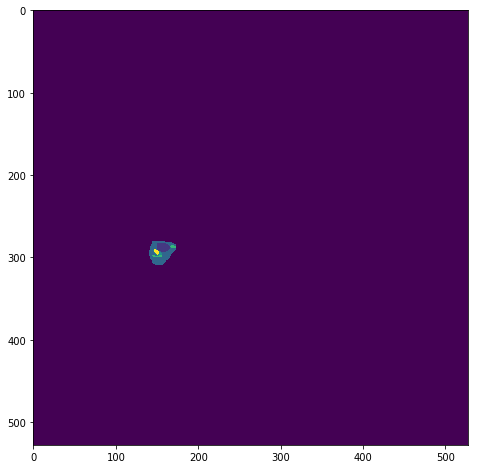

In [773]:
plt.figure(figsize=(8, 8))
plt.imshow(img)

In [777]:
xmin = np.min(np.where(d.pixel_array > 0)[0])
xmax = np.max(np.where(d.pixel_array > 0)[0])

ymin = np.min(np.where(d.pixel_array > 0)[1])
ymax = np.max(np.where(d.pixel_array > 0)[1])

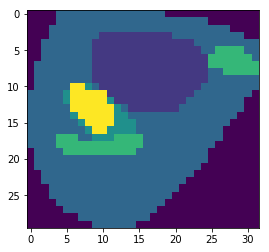

In [782]:
plt.imshow(img[xmin:xmax+1, ymin:ymax+1])

In [783]:
np.unique(img)

array([0, 1, 2, 3, 4, 6], dtype=int16)

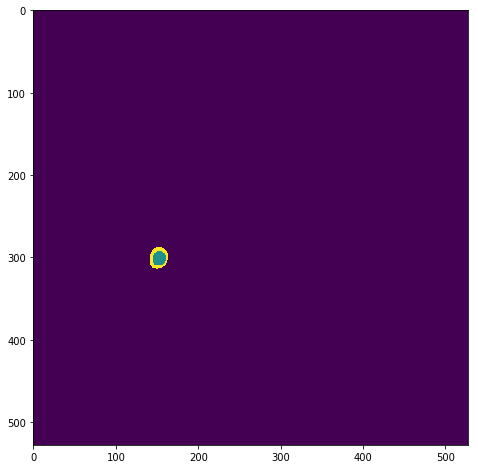

In [33]:
d = pydicom.dcmread("F:/Plaque_delin/MASSExport_MUMC011/SER_1001_sl0012_ph0001.dcm", force = True)
d.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
img = d.pixel_array

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

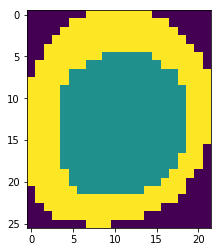

[0 1 2]


In [34]:
xmin = np.min(np.where(d.pixel_array > 0)[0])
xmax = np.max(np.where(d.pixel_array > 0)[0])

ymin = np.min(np.where(d.pixel_array > 0)[1])
ymax = np.max(np.where(d.pixel_array > 0)[1])

plt.imshow(img[xmin:xmax+1, ymin:ymax+1])
plt.show()

print (np.unique(img))

In [70]:
subs = ['MUMC011', 'MUMC013', 'MUMC014', 'MUMC015', 'MUMC016', 'MUMC017', 'MUMC019', 'MUMC020', 'MUMC021', 'MUMC022', 
        'MUMC024', 'MUMC025', 'MUMC026', 'MUMC027', 'MUMC028', 'MUMC029', 'MUMC030', 'MUMC032', 'MUMC033']

In [69]:
seqs = ['T1W', 'MPRAGE', 'TOF', 'T2W', 'T1W-PC']

In [81]:
for sub in subs:

    for i in range (1, 16):

        mask_name = glob.glob('F:/Plaque_delin/MASSExport_'+sub+'/*sl'+format(i, '04d')+'*.dcm')[0]
        mask = pydicom.dcmread(mask_name, force = True)
        mask.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_img = mask.pixel_array
        
        xmin = 1
        ymin = 1
        xmax = mask_img.shape[0]-2
        ymax = mask_img.shape[0]-2
        
        if np.sum(mask_img)>0: 
            xmin = np.min(np.where(mask_img > 0)[0])
            xmax = np.max(np.where(mask_img > 0)[0])
            ymin = np.min(np.where(mask_img > 0)[1])
            ymax = np.max(np.where(mask_img > 0)[1])

        for seq in seqs:
            
            dcm_name = glob.glob('F:/Plaque/'+sub+'/*'+seq+'*sl'+format(i, '04d')+'*.dcm')[0]
            dcm = pydicom.dcmread(dcm_name, force = True)
            dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
            dcm_img = dcm.pixel_array
            
            plt.figure(figsize=(8, 8))
            plt.imshow(dcm_img[xmin-1:xmax+2, ymin-1:ymax+2])
            plt.contour(mask_img[xmin-1:xmax+2, ymin-1:ymax+2], 
                        levels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], colors = 'r', linewidths = 1)
            plt.axis('off')
            plt.title(dcm_name)
            plt.savefig('F:/Plaque_check/'+sub+'_'+seq+'_'+format(i, '04d')+'.png')
            plt.close()

C:\Users\e.lavrova\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [76]:
dcm_name = "F:/Plaque/MUMC011/1_T1W_SER_1001_sl0002_ph0001.dcm"
mask_name = "F:/Plaque_delin/MASSExport_MUMC011/SER_1001_sl0002_ph0001.dcm"

dcm = pydicom.dcmread(dcm_name, force = True)
mask = pydicom.dcmread(mask_name, force = True)

dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
mask.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

dcm_img = dcm.pixel_array
mask_img = mask.pixel_array

xmin = np.min(np.where(mask_img > 0)[0])
xmax = np.max(np.where(mask_img > 0)[0])

ymin = np.min(np.where(mask_img > 0)[1])
ymax = np.max(np.where(mask_img > 0)[1])

plt.figure(figsize=(8, 8))
plt.imshow(dcm_img[xmin-1:xmax+2, ymin-1:ymax+2])
plt.contour(mask_img[xmin-1:xmax+2, ymin-1:ymax+2], levels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], colors = 'r', linewidths = 1.5)
plt.axis('off')
plt.title(dcm_name)
plt.savefig('test.png')
plt.close()
#plt.show()